<font size="+3">**Crop Diseases in Uganda**</font>

# Set the Environment

In [ ]:
import os
import random
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import sklearn.model_selection
from torchinfo import summary

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, models, transforms
from tqdm import tqdm

In [ ]:
print("torch version : ", torch.__version__)
print("torchvision version : ", torchvision.__version__)
print("numpy version : ", np.__version__)
print("matplotlib version : ", matplotlib.__version__)

!python --version

torch version :  2.2.2+cu121
torchvision version :  0.17.2+cu121
numpy version :  1.26.3
matplotlib version :  3.9.2
Python 3.11.0


In [ ]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print(f"Using {device} device.")

Using cuda device.


# Exploring our Data

In [ ]:
data_dir = "data_p2"
train_dir = os.path.join(data_dir,  "train")
print("Data directory:", train_dir)

Data directory: data_p2/train


In [ ]:
classes = os.listdir(train_dir)
classes

['cassava-healthy',
 'cassava-mosaic-disease-cmd',
 'cassava-brown-streak-disease-cbsd',
 'cassava-green-mottle-cgm',
 'cassava-bacterial-blight-cbb']

In [ ]:
def sample_images(data_path, classname):
    # Gets the files in the directory
    class_dir = os.path.join(data_path, classname)
    if not os.path.exists(class_dir):
        return "Invalid directory"
    image_list = os.listdir(class_dir)
    if len(image_list) < 4:
        return "Not enough images in folder"

    # Pick four random images
    images_sample = random.sample(image_list, 4)

    # Plot them
    plt.figure(figsize=(20, 20))
    for i in range(4):
        img_loc = os.path.join(class_dir, images_sample[i])
        img = PIL.Image.open(img_loc)
        plt.subplot(1, 4, i + 1)
        plt.imshow(img)
        plt.axis("off")

cassava-healthy


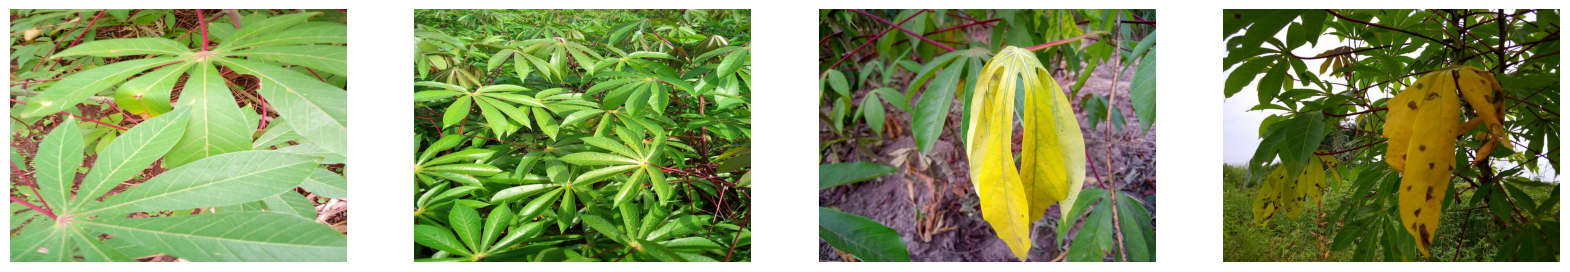

In [ ]:
class_name = classes[0]
print(class_name)

sample_images(train_dir, class_name)

cassava-mosaic-disease-cmd


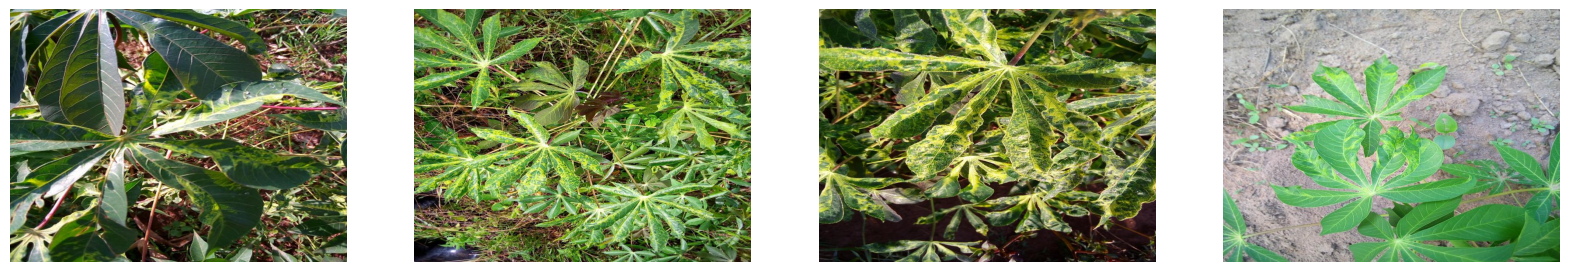

In [ ]:
class_name = classes[1]
print(class_name)
sample_images(train_dir, class_name)

cassava-brown-streak-disease-cbsd


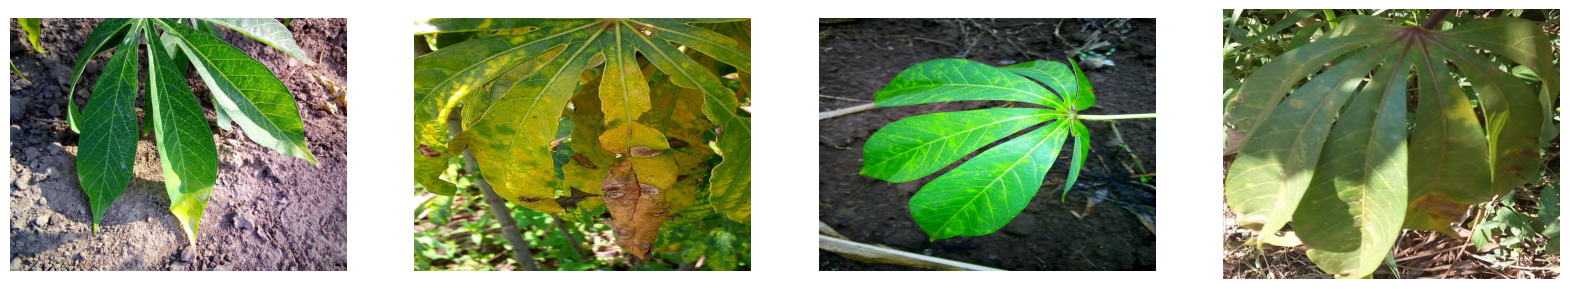

In [ ]:
class_name = classes[2]
print(class_name)
sample_images(train_dir, class_name)

cassava-green-mottle-cgm


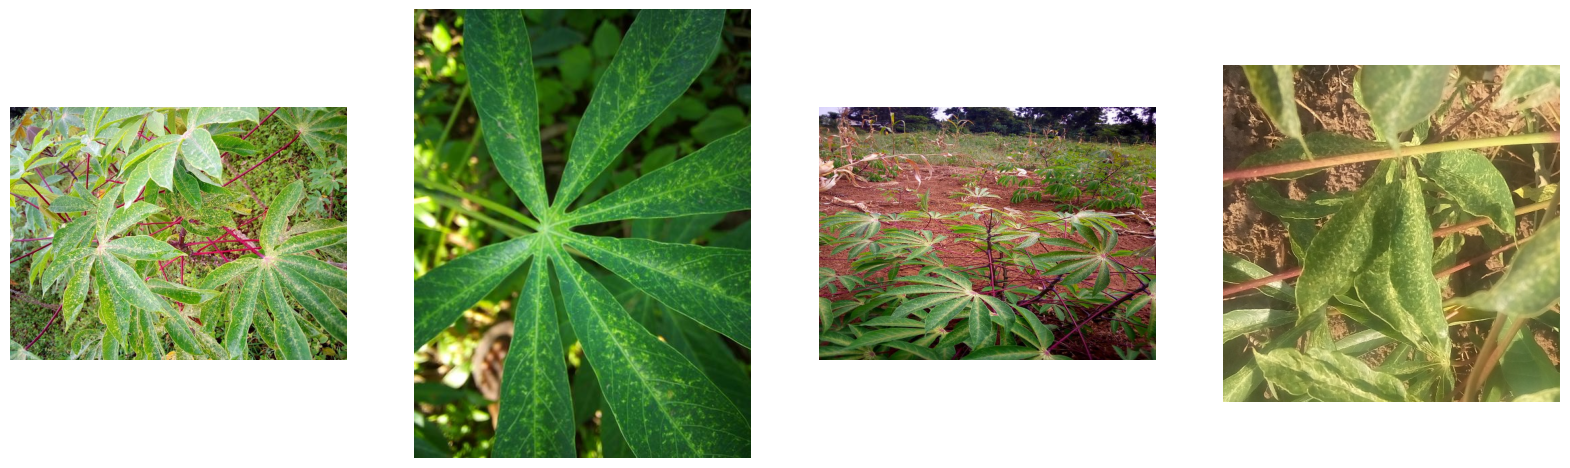

In [ ]:
class_name = classes[3]
print(class_name)
sample_images(train_dir, class_name)

cassava-bacterial-blight-cbb


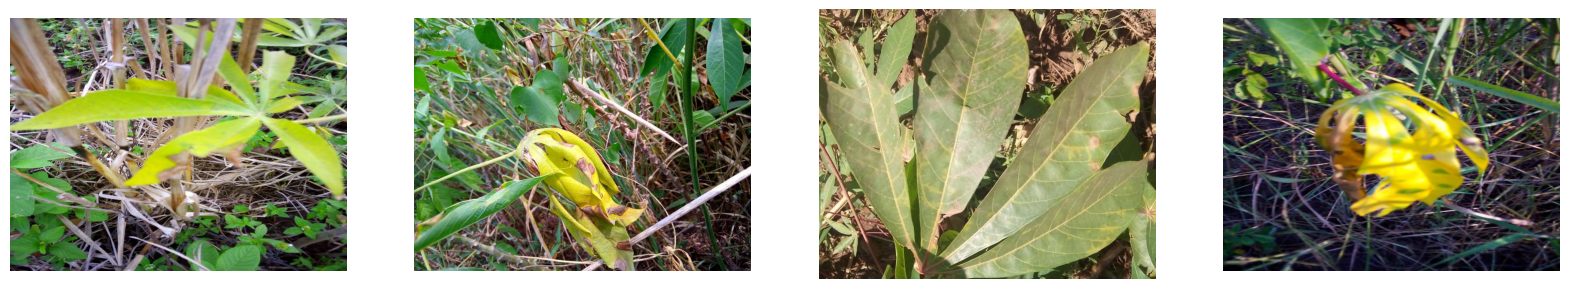

In [ ]:
class_name = classes[4]
print(class_name)
sample_images(train_dir, class_name)

## Prepare Data

In [ ]:
class ConvertToRGB(object):
    def __call__(self, img):
        if img.mode != "RGB":
            img = img.convert("RGB")
        return img

In [ ]:
transform_basic = transforms.Compose(
    [
        ConvertToRGB(),
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ]
)

In [ ]:
batch_size = 32
dataset = datasets.ImageFolder(root=train_dir, transform=transform_basic)
dataset_loader = DataLoader(dataset, batch_size=batch_size)
batch_shape = next(iter(dataset_loader))[0].shape
print("Getting batches of shape:", batch_shape)

Getting batches of shape: torch.Size([32, 3, 224, 224])


## Data Normalization

In [ ]:
def get_mean_std(loader):
    """Computes the mean and standard deviation of image data.

    Input: a `DataLoader` producing tensors of shape [batch_size, channels, pixels_x, pixels_y]
    Output: the mean of each channel as a tensor, the standard deviation of each channel as a tensor
            formatted as a tuple (means[channels], std[channels])"""

    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in tqdm(loader, desc="Computing mean and std", leave=False):
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_squared_sum += torch.mean(data**2, dim=[0, 2, 3])
        num_batches += 1
    mean = channels_sum / num_batches
    std = (channels_squared_sum / num_batches - mean**2) ** 0.5

    return mean, std

In [ ]:
mean, std = get_mean_std(dataset_loader)
print(f"Mean: {mean}")
print(f"Standard deviation: {std}")

Mean: tensor([0.4301, 0.4933, 0.3072])
Standard deviation: tensor([0.2186, 0.2216, 0.2100])


In [ ]:
transform_norm = transforms.Compose(
    [
        ConvertToRGB(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ]
)

In [ ]:
norm_dataset = datasets.ImageFolder(root=train_dir, transform=transform_norm)
norm_loader = DataLoader(norm_dataset, batch_size=32)
batch_shape = next(iter(norm_loader))[0].shape
print("Getting batches of shape:", batch_shape)

Getting batches of shape: torch.Size([32, 3, 224, 224])


In [ ]:
norm_mean, norm_std = get_mean_std(norm_loader)
print(f"Mean: {norm_mean}")
print(f"Standard deviation: {norm_std}")

Mean: tensor([-4.4082e-07,  2.5858e-07, -3.7493e-07])
Standard deviation: tensor([1.0000, 1.0000, 1.0000])


## Train-Validation Split

In [ ]:
from training import class_counts

In [ ]:
train_dataset, val_dataset = random_split(norm_dataset, [0.8,0.2])
length_train = len(train_dataset)

length_val = len(val_dataset)
length_dataset = len(norm_dataset)

percent_train = np.round(100 * length_train / length_dataset, 2)
percent_val = np.round(100 * length_val / length_dataset, 2)

print(f"Train data is {percent_train}% of full data")
print(f"Validation data is {percent_val}% of full data")

Train data is 80.0% of full data
Validation data is 20.0% of full data


  0%|          | 0/6092 [00:00<?, ?it/s]

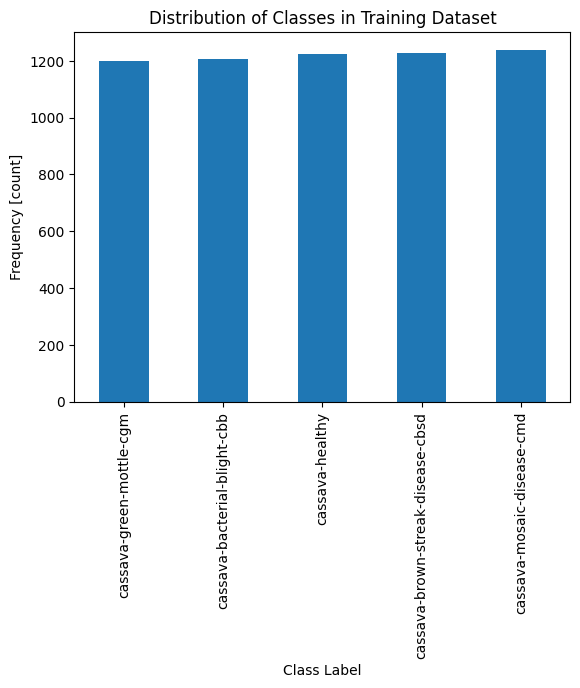

In [ ]:
train_counts = class_counts(train_dataset)

# Make a bar chart from the function output
train_counts.sort_values().plot(kind="bar")

# Add axis labels and title
plt.xlabel("Class Label")
plt.ylabel("Frequency [count]")
plt.title("Distribution of Classes in Training Dataset");

  0%|          | 0/1523 [00:00<?, ?it/s]

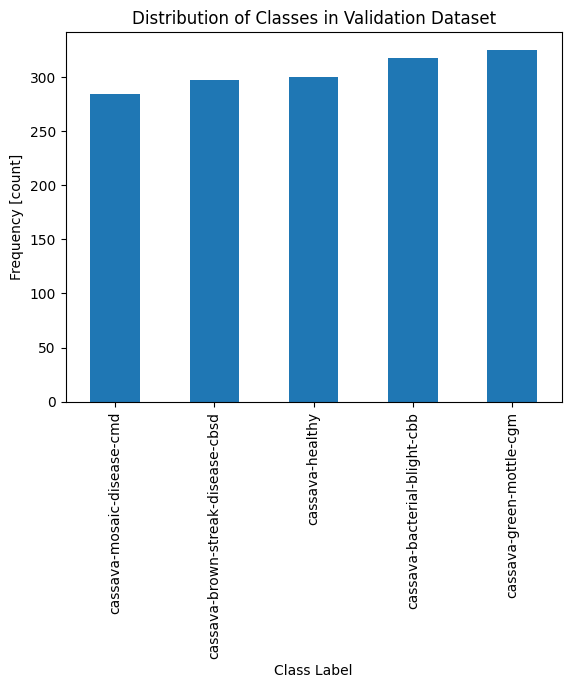

In [ ]:
val_counts = class_counts(val_dataset)

# Make a bar chart from the function output
val_counts.sort_values().plot(kind="bar")

# Add axis labels and title
plt.xlabel("Class Label")
plt.ylabel("Frequency [count]")
plt.title("Distribution of Classes in Validation Dataset");

In [ ]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

print(type(train_loader))
print(type(val_loader))

<class 'torch.utils.data.dataloader.DataLoader'>
<class 'torch.utils.data.dataloader.DataLoader'>


# Defining and Training a Model

### Building a Convolutional Neural Network

In [ ]:
# Important! Don't change this
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model = torch.nn.Sequential()

conv1_n_kernels = 16
conv1 = torch.nn.Conv2d(
    in_channels=3, out_channels=conv1_n_kernels, kernel_size=(3, 3), padding=1
)
max_pool_size = 4
max_pool1 = torch.nn.MaxPool2d(max_pool_size)
model.append(conv1)
model.append(torch.nn.ReLU())
model.append(max_pool1)

conv2_n_kernels = 32
conv2 = torch.nn.Conv2d(
    in_channels=16, out_channels=conv2_n_kernels, kernel_size=(3, 3), padding=1
)
max_pool2 = torch.nn.MaxPool2d(max_pool_size)
model.append(conv2)
model.append(torch.nn.ReLU())
model.append(max_pool2)

conv3_n_kernels = 64
conv3 = torch.nn.Conv2d(32, conv3_n_kernels, 3, padding=1)
max_pool3 = torch.nn.MaxPool2d(max_pool_size)
model.append(conv3)
model.append(torch.nn.ReLU())
model.append(max_pool3)

model.append(torch.nn.Flatten())
model.append(torch.nn.Dropout())

linear1 = torch.nn.Linear(in_features=576, out_features=500)
model.append(linear1)
model.append(torch.nn.ReLU())
model.append(torch.nn.Dropout())

n_classes = 5
output_layer = torch.nn.Linear(500, n_classes)
model.append(output_layer)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Dropout(p=0.5, inplace=False)
  (11): Linear(in_features=576, out_features=500, bias=True)
  (12): ReLU()
  (13): Dropout(p=0.5, inplace=False)
  (14): Linear(in_features=500, out_features=5, bias=True)
)

### Training the Model

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(loss_fn)
print("----------------------")
print(optimizer)

CrossEntropyLoss()
----------------------
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


In [ ]:
# Move the model to the device before calling summary
model.to(device)


height = 224
width = 224
summary(model, input_size=batch_shape)

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [32, 5]                   --
├─Conv2d: 1-1                            [32, 16, 224, 224]        448
├─ReLU: 1-2                              [32, 16, 224, 224]        --
├─MaxPool2d: 1-3                         [32, 16, 56, 56]          --
├─Conv2d: 1-4                            [32, 32, 56, 56]          4,640
├─ReLU: 1-5                              [32, 32, 56, 56]          --
├─MaxPool2d: 1-6                         [32, 32, 14, 14]          --
├─Conv2d: 1-7                            [32, 64, 14, 14]          18,496
├─ReLU: 1-8                              [32, 64, 14, 14]          --
├─MaxPool2d: 1-9                         [32, 64, 3, 3]            --
├─Flatten: 1-10                          [32, 576]                 --
├─Dropout: 1-11                          [32, 576]                 --
├─Linear: 1-12                           [32, 500]                 288,500
├─

In [ ]:
from training import train
train_losses, valid_losses, train_accuracies, valid_accuracies = train(model, optimizer, loss_fn, train_loader, val_loader, epochs=15, device=device)

Training:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 1
    Training loss: 1.41
    Training accuracy: 0.36
    Validation loss: 1.41
    Validation accuracy: 0.35


Training:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 2
    Training loss: 1.32
    Training accuracy: 0.43
    Validation loss: 1.32
    Validation accuracy: 0.41


Training:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 3
    Training loss: 1.28
    Training accuracy: 0.46
    Validation loss: 1.28
    Validation accuracy: 0.46


Training:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 4
    Training loss: 1.25
    Training accuracy: 0.48
    Validation loss: 1.27
    Validation accuracy: 0.46


Training:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 5
    Training loss: 1.24
    Training accuracy: 0.47
    Validation loss: 1.30
    Validation accuracy: 0.43


Training:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 6
    Training loss: 1.13
    Training accuracy: 0.54
    Validation loss: 1.20
    Validation accuracy: 0.52


Training:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 7
    Training loss: 1.13
    Training accuracy: 0.54
    Validation loss: 1.21
    Validation accuracy: 0.48


Training:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 8
    Training loss: 1.12
    Training accuracy: 0.54
    Validation loss: 1.21
    Validation accuracy: 0.48


Training:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 9
    Training loss: 1.07
    Training accuracy: 0.58
    Validation loss: 1.17
    Validation accuracy: 0.52


Training:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 10
    Training loss: 1.02
    Training accuracy: 0.59
    Validation loss: 1.17
    Validation accuracy: 0.52


Training:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 11
    Training loss: 0.96
    Training accuracy: 0.62
    Validation loss: 1.12
    Validation accuracy: 0.55


Training:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 12
    Training loss: 0.97
    Training accuracy: 0.61
    Validation loss: 1.14
    Validation accuracy: 0.53


Training:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 13
    Training loss: 0.92
    Training accuracy: 0.64
    Validation loss: 1.14
    Validation accuracy: 0.55


Training:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 14
    Training loss: 0.88
    Training accuracy: 0.66
    Validation loss: 1.12
    Validation accuracy: 0.55


Training:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/191 [00:00<?, ?it/s]

Scoring:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch: 15
    Training loss: 0.90
    Training accuracy: 0.67
    Validation loss: 1.14
    Validation accuracy: 0.53


### Evaluate the Model

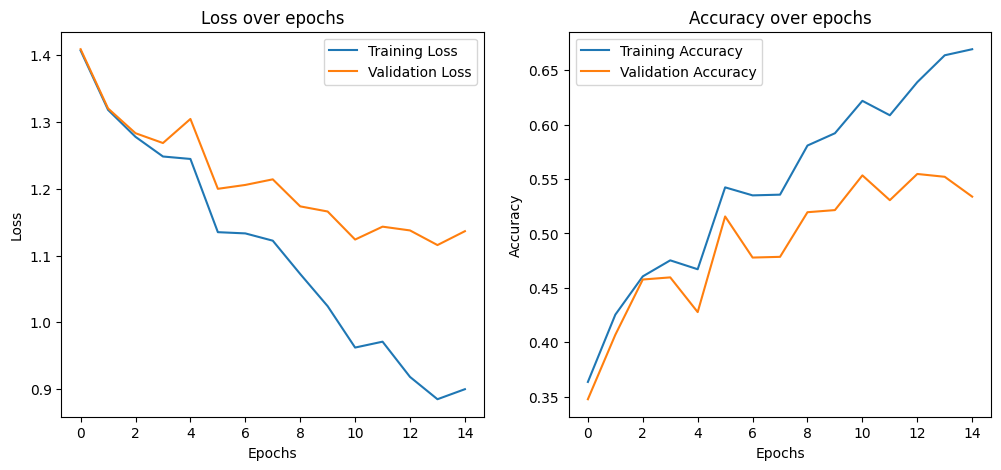

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Training Loss")
plt.plot(valid_losses, label="Validation Loss")
plt.title("Loss over epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Training Accuracy")
plt.plot(valid_accuracies, label="Validation Accuracy")
plt.title("Accuracy over epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

In [ ]:
from training import predict

probabilities_val = predict(model, val_loader, device)
predictions_val = torch.argmax(probabilities_val, dim=1)

print(predictions_val[:5])

Predicting:   0%|          | 0/48 [00:00<?, ?it/s]

tensor([3, 4, 0, 0, 4], device='cuda:0')


In [ ]:
targets_val = torch.cat(
    [labels for _, labels in tqdm(val_loader, desc="Get Labels")]
).to(device)

Get Labels: 100%|██████████| 48/48 [00:21<00:00,  2.26it/s]


<Figure size 1000x800 with 0 Axes>

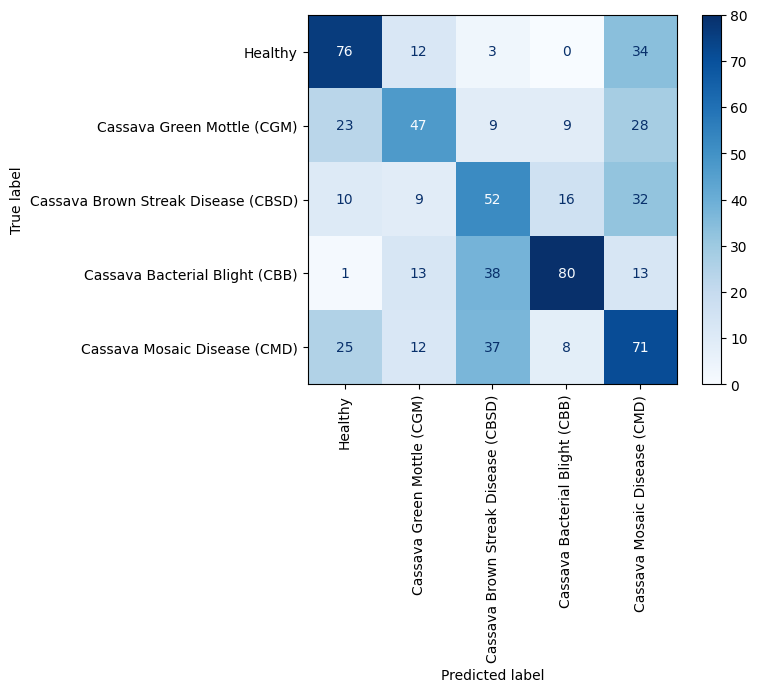

In [ ]:
cm = confusion_matrix(targets_val.cpu(), predictions_val.cpu())

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)

# Set figure size
plt.figure(figsize=(10, 8))

disp.plot(cmap=plt.cm.Blues, xticks_rotation="vertical")
plt.show()

# Transfer Learning

## Implementing Transfer Learning

In [ ]:
model = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 210MB/s]


In [ ]:
test_batch = next(iter(train_loader))[0]
# Get the shape of a single image from the batch, excluding the batch size
batch_shape = test_batch[0].shape

model.to(device)  # Ensure the model is on the desired device
test_batch = test_batch.to(device)  # Move the input data to the desired device

# Create the model summary
summary(model, input_size=batch_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
for params in model.parameters():
    params.requires_grad = False

In [ ]:
# Move our test_batch to device
test_batch_cuda = test_batch.to(device)

print("Test batch is running on:", test_batch_cuda.device)

Test batch is running on: cuda:0


In [ ]:
model_test_out = model(test_batch_cuda)
model_test_shape = model_test_out.shape

print("Output shape:", model_test_shape)

Output shape: torch.Size([32, 1000])


## Modifying the Network to Our Task

In [ ]:
# Important! Don't change this
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get in_features from the last linear layer before modification
# model.fc is a Linear layer, so we directly access its in_features attribute
in_features = model.fc.in_features

modified_last_layer = nn.Sequential()

dense_layer = torch.nn.Linear(in_features=in_features, out_features=256)
modified_last_layer.append(dense_layer)

relu = torch.nn.ReLU()
modified_last_layer.append(relu)

modified_last_layer.append(nn.Dropout(p=0.5))

output_layer = torch.nn.Linear(in_features=256, out_features=5)
modified_last_layer.append(output_layer)

# Assign `modified_last_layer` to `model.fc`
model.fc = modified_last_layer

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## K-fold Cross-Validation

In [ ]:
k = 5

kfold_splitter = sklearn.model_selection.KFold(n_splits=k, shuffle=True, random_state=42)

train_nums, val_nums = next(kfold_splitter.split(range(100)))
fold_fraction = len(val_nums) / (len(train_nums) + len(val_nums))
print(f"One fold is {100*fold_fraction:.2f}%")

One fold is 20.00%


## Training with k-fold

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
model.fc

Sequential(
  (0): Linear(in_features=2048, out_features=256, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=256, out_features=5, bias=True)
)

In [ ]:
def reset_classifier(model):
    model.fc.get_submodule("0").reset_parameters()
    model.fc.get_submodule("3").reset_parameters()

In [ ]:
num_epochs = 10

In [ ]:
from training import predict, train

In [ ]:
# you can safely skip this cell and load the model in the next cell

training_records = {}
fold_count = 0

for train_idx, val_idx in kfold_splitter.split(np.arange(len(dataset))):
    fold_count += 1
    print("*****Fold {}*****".format(fold_count))

    # Make train and validation data loaders
    train_dataset = torch.utils.data.Subset(norm_dataset, train_idx)
    val_dataset = torch.utils.data.Subset(norm_dataset, val_idx)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    # Reset the model
    reset_classifier(model)

    # Ensure model and data are on the same device
    model.to(device) # Make sure the model is on the correct device

    # Train
    train_losses, val_losses, train_accuracies, val_accuracies = train(
        model,
        optimizer,
        loss_fn,
        train_loader,
        val_loader,
        epochs=num_epochs,
        device=device,
        use_train_accuracy=False,
    )

    # Save training results for graphing
    training_records[fold_count] = {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "val_accuracies": val_accuracies,
    }

    print("\n\n")

*****Fold 1*****


Training:   0%|          | 0/83 [00:00<?, ?it/s]

Scoring:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 1
    Training loss: 1.35
    Validation loss: 1.13
    Validation accuracy: 0.56


Training:   0%|          | 0/83 [00:00<?, ?it/s]

Scoring:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 2
    Training loss: 1.10
    Validation loss: 1.15
    Validation accuracy: 0.57


Training:   0%|          | 0/83 [00:00<?, ?it/s]

Scoring:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 3
    Training loss: 1.00
    Validation loss: 1.02
    Validation accuracy: 0.61


Training:   0%|          | 0/83 [00:00<?, ?it/s]

Scoring:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 4
    Training loss: 0.92
    Validation loss: 1.04
    Validation accuracy: 0.61


Training:   0%|          | 0/83 [00:00<?, ?it/s]

Scoring:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 5
    Training loss: 0.85
    Validation loss: 1.16
    Validation accuracy: 0.56


Training:   0%|          | 0/83 [00:00<?, ?it/s]

Scoring:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 6
    Training loss: 0.79
    Validation loss: 1.09
    Validation accuracy: 0.58


Training:   0%|          | 0/83 [00:00<?, ?it/s]

Scoring:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 7
    Training loss: 0.75
    Validation loss: 1.04
    Validation accuracy: 0.60


Training:   0%|          | 0/83 [00:00<?, ?it/s]

Scoring:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 8
    Training loss: 0.71
    Validation loss: 1.12
    Validation accuracy: 0.60


Training:   0%|          | 0/83 [00:00<?, ?it/s]

Scoring:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 9
    Training loss: 0.66
    Validation loss: 1.09
    Validation accuracy: 0.60


Training:   0%|          | 0/83 [00:00<?, ?it/s]

Scoring:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 10
    Training loss: 0.59
    Validation loss: 1.17
    Validation accuracy: 0.60



*****Fold 2*****


Training:   0%|          | 0/83 [00:00<?, ?it/s]

Scoring:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 1
    Training loss: 1.32
    Validation loss: 1.12
    Validation accuracy: 0.54


Training:   0%|          | 0/83 [00:00<?, ?it/s]

Scoring:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 2
    Training loss: 1.09
    Validation loss: 1.05
    Validation accuracy: 0.57


Training:   0%|          | 0/83 [00:00<?, ?it/s]

Scoring:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 3
    Training loss: 0.96
    Validation loss: 1.02
    Validation accuracy: 0.57


Training:   0%|          | 0/83 [00:00<?, ?it/s]

Scoring:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 4
    Training loss: 0.89
    Validation loss: 1.06
    Validation accuracy: 0.56


Training:   0%|          | 0/83 [00:00<?, ?it/s]

Scoring:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 5
    Training loss: 0.83
    Validation loss: 1.07
    Validation accuracy: 0.57


Training:   0%|          | 0/83 [00:00<?, ?it/s]

Scoring:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 6
    Training loss: 0.77
    Validation loss: 1.01
    Validation accuracy: 0.59


Training:   0%|          | 0/83 [00:00<?, ?it/s]

Scoring:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 7
    Training loss: 0.71
    Validation loss: 1.03
    Validation accuracy: 0.59


Training:   0%|          | 0/83 [00:00<?, ?it/s]

Scoring:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 8
    Training loss: 0.69
    Validation loss: 1.06
    Validation accuracy: 0.58


Training:   0%|          | 0/83 [00:00<?, ?it/s]

Scoring:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 9
    Training loss: 0.65
    Validation loss: 1.06
    Validation accuracy: 0.58


Training:   0%|          | 0/83 [00:00<?, ?it/s]

Scoring:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 10
    Training loss: 0.59
    Validation loss: 1.10
    Validation accuracy: 0.57



*****Fold 3*****


Training:   0%|          | 0/83 [00:00<?, ?it/s]

Scoring:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 1
    Training loss: 1.31
    Validation loss: 1.14
    Validation accuracy: 0.52


Training:   0%|          | 0/83 [00:00<?, ?it/s]

Scoring:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 2
    Training loss: 1.07
    Validation loss: 1.06
    Validation accuracy: 0.58


Training:   0%|          | 0/83 [00:00<?, ?it/s]

Scoring:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 3
    Training loss: 0.98
    Validation loss: 1.03
    Validation accuracy: 0.56


Training:   0%|          | 0/83 [00:00<?, ?it/s]

Scoring:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 4
    Training loss: 0.87
    Validation loss: 1.03
    Validation accuracy: 0.58


Training:   0%|          | 0/83 [00:00<?, ?it/s]

Scoring:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 5
    Training loss: 0.81
    Validation loss: 1.05
    Validation accuracy: 0.57


Training:   0%|          | 0/83 [00:00<?, ?it/s]

Scoring:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 6
    Training loss: 0.74
    Validation loss: 1.16
    Validation accuracy: 0.55


Training:   0%|          | 0/83 [00:00<?, ?it/s]

Scoring:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 7
    Training loss: 0.72
    Validation loss: 1.09
    Validation accuracy: 0.55


Training:   0%|          | 0/83 [00:00<?, ?it/s]

Scoring:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 8
    Training loss: 0.67
    Validation loss: 1.15
    Validation accuracy: 0.56


Training:   0%|          | 0/83 [00:00<?, ?it/s]

Scoring:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 9
    Training loss: 0.62
    Validation loss: 1.14
    Validation accuracy: 0.57


Training:   0%|          | 0/83 [00:00<?, ?it/s]

Scoring:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 10
    Training loss: 0.58
    Validation loss: 1.16
    Validation accuracy: 0.56



*****Fold 4*****


Training:   0%|          | 0/83 [00:00<?, ?it/s]

Scoring:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 1
    Training loss: 1.36
    Validation loss: 1.08
    Validation accuracy: 0.58


Training:   0%|          | 0/83 [00:00<?, ?it/s]

Scoring:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 2
    Training loss: 1.08
    Validation loss: 0.97
    Validation accuracy: 0.60


Training:   0%|          | 0/83 [00:00<?, ?it/s]

Scoring:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 3
    Training loss: 1.00
    Validation loss: 0.97
    Validation accuracy: 0.61


Training:   0%|          | 0/83 [00:00<?, ?it/s]

Scoring:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 4
    Training loss: 0.91
    Validation loss: 0.97
    Validation accuracy: 0.61


Training:   0%|          | 0/83 [00:00<?, ?it/s]

Scoring:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 5
    Training loss: 0.86
    Validation loss: 0.94
    Validation accuracy: 0.61


Training:   0%|          | 0/83 [00:00<?, ?it/s]

Scoring:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 6
    Training loss: 0.78
    Validation loss: 0.95
    Validation accuracy: 0.62


Training:   0%|          | 0/83 [00:00<?, ?it/s]

Scoring:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 7
    Training loss: 0.74
    Validation loss: 0.97
    Validation accuracy: 0.58


Training:   0%|          | 0/83 [00:00<?, ?it/s]

Scoring:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 8
    Training loss: 0.68
    Validation loss: 0.97
    Validation accuracy: 0.61


Training:   0%|          | 0/83 [00:00<?, ?it/s]

Scoring:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 9
    Training loss: 0.64
    Validation loss: 1.02
    Validation accuracy: 0.60


Training:   0%|          | 0/83 [00:00<?, ?it/s]

Scoring:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 10
    Training loss: 0.60
    Validation loss: 0.99
    Validation accuracy: 0.62



*****Fold 5*****


Training:   0%|          | 0/83 [00:00<?, ?it/s]

Scoring:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 1
    Training loss: 1.36
    Validation loss: 1.14
    Validation accuracy: 0.51


Training:   0%|          | 0/83 [00:00<?, ?it/s]

Scoring:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 2
    Training loss: 1.08
    Validation loss: 1.03
    Validation accuracy: 0.60


Training:   0%|          | 0/83 [00:00<?, ?it/s]

Scoring:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 3
    Training loss: 0.97
    Validation loss: 0.99
    Validation accuracy: 0.61


Training:   0%|          | 0/83 [00:00<?, ?it/s]

Scoring:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 4
    Training loss: 0.92
    Validation loss: 0.98
    Validation accuracy: 0.62


Training:   0%|          | 0/83 [00:00<?, ?it/s]

Scoring:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 5
    Training loss: 0.83
    Validation loss: 1.00
    Validation accuracy: 0.60


Training:   0%|          | 0/83 [00:00<?, ?it/s]

Scoring:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 6
    Training loss: 0.79
    Validation loss: 1.03
    Validation accuracy: 0.59


Training:   0%|          | 0/83 [00:00<?, ?it/s]

Scoring:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 7
    Training loss: 0.72
    Validation loss: 1.03
    Validation accuracy: 0.60


Training:   0%|          | 0/83 [00:00<?, ?it/s]

Scoring:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 8
    Training loss: 0.68
    Validation loss: 1.07
    Validation accuracy: 0.59


Training:   0%|          | 0/83 [00:00<?, ?it/s]

Scoring:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 9
    Training loss: 0.65
    Validation loss: 1.09
    Validation accuracy: 0.58


Training:   0%|          | 0/83 [00:00<?, ?it/s]

Scoring:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 10
    Training loss: 0.58
    Validation loss: 1.08
    Validation accuracy: 0.58





In [ ]:
import pickle

# Save the training_records dictionary to a .pkl file
with open('training_records.pkl', 'wb') as fp:
    pickle.dump(training_records, fp)

print("Training records saved to training_records.pkl")

with open('training_records.pkl', 'rb') as fp:
    training_records = pickle.load(fp)

Training records saved to training_records.pkl


## Model Performance

In [ ]:
print(type(training_records))
training_records.keys()

<class 'dict'>


dict_keys([1, 2, 3, 4, 5])

In [ ]:
print(type(training_records[1]))
training_records[1].keys()

<class 'dict'>


dict_keys(['train_losses', 'val_losses', 'val_accuracies'])

In [ ]:
training_records[1]["train_losses"]

[1.2573940041655391,
 1.0369858069006581,
 0.9532191420728567,
 0.9031010592602149,
 0.8534171506126539,
 0.7998687047670331]

In [ ]:
def plot_all_folds(data, measurement):
    for fold in data.keys():
        plt.plot(data[fold][measurement], label=f"Fold {fold}, {measurement}")
    plt.xlabel("Epochs")
    plt.legend()

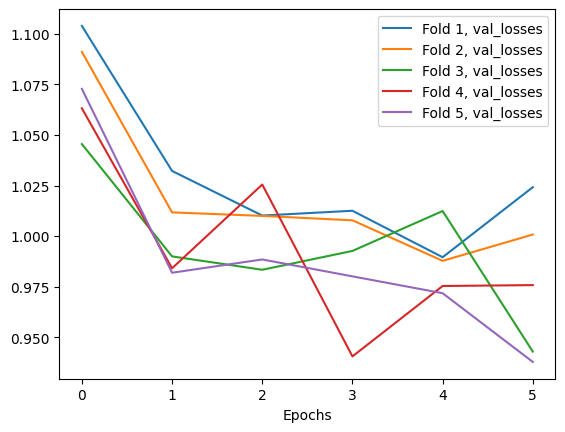

In [ ]:
# Plot the validation losses
plot_all_folds(training_records, "val_losses")

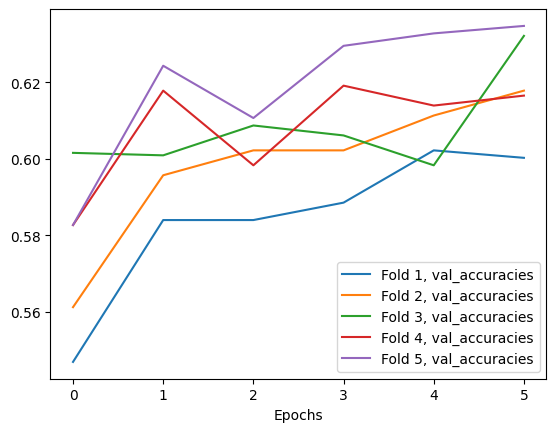

In [ ]:
# Plot the validation accuracies
plot_all_folds(training_records, "val_accuracies")

In [ ]:
def fold_average(data, measurement):
    return np.mean([data[fold][measurement][-1] for fold in data])


for measurement in training_records[1].keys():
    avg_measure = fold_average(training_records, measurement)
    print(f"Averaged {measurement}: {avg_measure}")

Averaged train_losses: 0.5870877121629868
Averaged val_losses: 1.0988704758385817
Averaged val_accuracies: 0.5851190476190476


In [ ]:
# If you loaded the pre-trained model, make sure you have the correct validation set
_, val_idx = list(kfold_splitter.split(np.arange(len(dataset))))[-1]
val_dataset = torch.utils.data.Subset(dataset, val_idx)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [ ]:
probabilities_val = predict(model, val_loader, device)
predictions_val = torch.argmax(probabilities_val, dim=1)

print(predictions_val)

Predicting:   0%|          | 0/48 [00:00<?, ?it/s]

tensor([0, 3, 3,  ..., 2, 1, 2], device='cuda:0')


In [ ]:
targets_val = torch.cat(
    [labels for _, labels in tqdm(val_loader, desc="Get Labels")]
).to(device)

Get Labels: 100%|██████████| 21/21 [00:05<00:00,  4.06it/s]


<Figure size 1000x800 with 0 Axes>

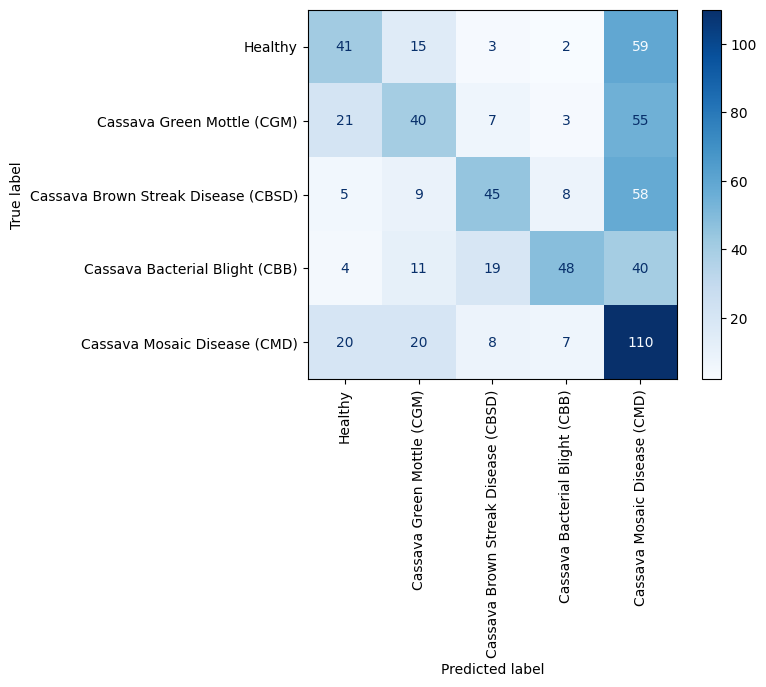

In [ ]:
cm = confusion_matrix(targets_val.cpu(), predictions_val.cpu())

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)

# Set figure size
plt.figure(figsize=(10, 8))

disp.plot(cmap=plt.cm.Blues, xticks_rotation="vertical")
plt.show()

# Training the Model with Callbacks

In [ ]:
# Period of learning rate decay
step_size = 4
# Multiplicative factor of learning rate decay
gamma = 0.2

# Initialize the learning rate scheduler
scheduler = StepLR(
    optimizer,
    step_size=step_size,
    gamma=gamma,
)

print(type(scheduler))

<class 'torch.optim.lr_scheduler.StepLR'>


In [ ]:
def early_stopping(validation_loss, best_val_loss, counter):
    """Function that implements Early Stopping"""

    stop = False

    if validation_loss < best_val_loss:
        counter = 0
    else:
        counter += 1

    # Check if counter is >= patience (5 epochs in our case)
    # Set stop variable accordingly
    if counter>= 5:
         stop = True

    return counter, stop

In [ ]:
def checkpointing(validation_loss, best_val_loss, model, optimizer, save_path):

    # Create the directory if it doesn't exist
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    if validation_loss < best_val_loss:
        torch.save(
            {
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "loss": best_val_loss,
            },
            save_path,
        )
        print(f"Checkpoint saved with validation loss {validation_loss:.4f}")

In [ ]:
from training_py import score, train_epoch


def train(
    model,
    optimizer,
    loss_fn,
    train_loader,
    val_loader,
    epochs=20,
    device="cpu",
    scheduler=None,
    checkpoint_path=None,
    early_stopping=None,
):
    # Track the model progress over epochs
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    learning_rates = []

    # Create the trackers if needed for checkpointing and early stopping
    best_val_loss = float("inf")
    early_stopping_counter = 0

    print("Model evaluation before start of training...")
    # Test on training set
    train_loss, train_accuracy = score(model, train_loader, loss_fn, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    # Test on validation set
    validation_loss, validation_accuracy = score(model, val_loader, loss_fn, device)
    val_losses.append(validation_loss)
    val_accuracies.append(validation_accuracy)

    for epoch in range(1, epochs + 1):
        print("\n")
        print(f"Starting epoch {epoch}/{epochs}")

        # Train one epoch
        train_epoch(model, optimizer, loss_fn, train_loader, device)

        # Evaluate training results
        train_loss, train_accuracy = score(model, train_loader, loss_fn, device)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Test on validation set
        validation_loss, validation_accuracy = score(model, val_loader, loss_fn, device)
        val_losses.append(validation_loss)
        val_accuracies.append(validation_accuracy)

        print(f"Epoch: {epoch}")
        print(f"Training loss: {train_loss:.4f}")
        print(f"Training accuracy: {train_accuracy*100:.4f}%")
        print(f"Validation loss: {validation_loss:.4f}")
        print(f"Validation accuracy: {validation_accuracy*100:.4f}%")

        # # Log the learning rate and have the scheduler adjust it
        lr = optimizer.param_groups[0]["lr"]
        learning_rates.append(lr)
        if scheduler:
            scheduler.step()

        # Checkpointing saves the model if current model is better than best so far
        if checkpoint_path:
            checkpointing(
                validation_loss, best_val_loss, model, optimizer, checkpoint_path
            )

        # Early Stopping
        if early_stopping:
            early_stopping_counter, stop = early_stopping(
                validation_loss, best_val_loss, early_stopping_counter
            )
            if stop:
                print(f"Early stopping triggered after {epoch} epochs")
                break

        if validation_loss < best_val_loss:
            best_val_loss = validation_loss

    return (
        learning_rates,
        train_losses,
        val_losses,
        train_accuracies,
        val_accuracies,
        epoch,
    )

In [ ]:
epochs_to_train = 50

train_results = train(
    model,
    optimizer,
    loss_fn,
    train_loader,
    val_loader,
    epochs=epochs_to_train,
    device=device,
    scheduler=scheduler,
    checkpoint_path="model/LR_model.pth",
    early_stopping=early_stopping,
)

(
    learning_rates,
    train_losses,
    valid_losses,
    train_accuracies,
    valid_accuracies,
    epochs,
) = train_results

In [ ]:
print(f"Training went on for {epochs} number of epochs before it stopped.")

Training went on for 15 number of epochs before it stopped.


## Evaluation of the Training Process and the Model

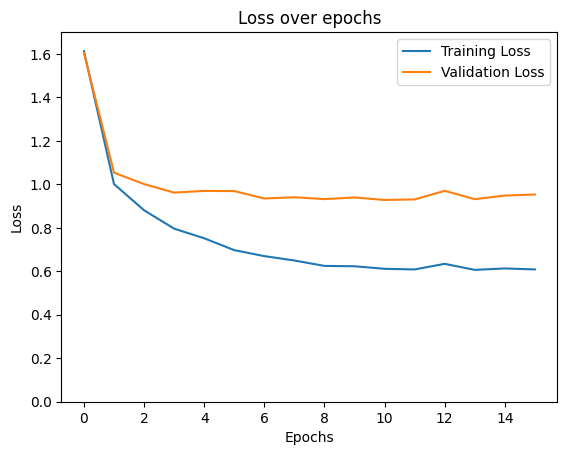

In [ ]:
plt.plot(train_losses, label="Training Loss")
plt.plot(valid_losses, label="Validation Loss")
plt.ylim([0, 1.7])
plt.title("Loss over epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend();

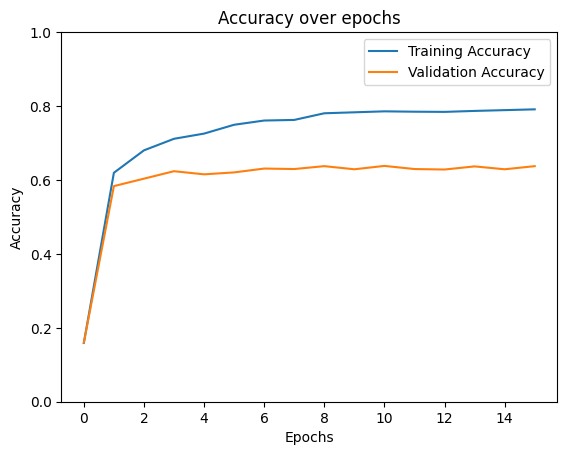

In [ ]:
# Plot train accuracies, use label="Training Accuracy"
plt.plot(train_accuracies, label="Training Accuracy")
# Plot validation accuracies, use label="Validation Accuracy"
plt.plot(valid_accuracies, label="Validation Accuracy")
plt.ylim([0, 1])
plt.title("Accuracy over epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend();

In [ ]:
probabilities_val = predict(model, val_loader, device)
predictions_val = torch.argmax(probabilities_val, dim=1)

Get Labels: 100%|██████████| 21/21 [00:05<00:00,  3.56it/s]


<Figure size 1000x800 with 0 Axes>

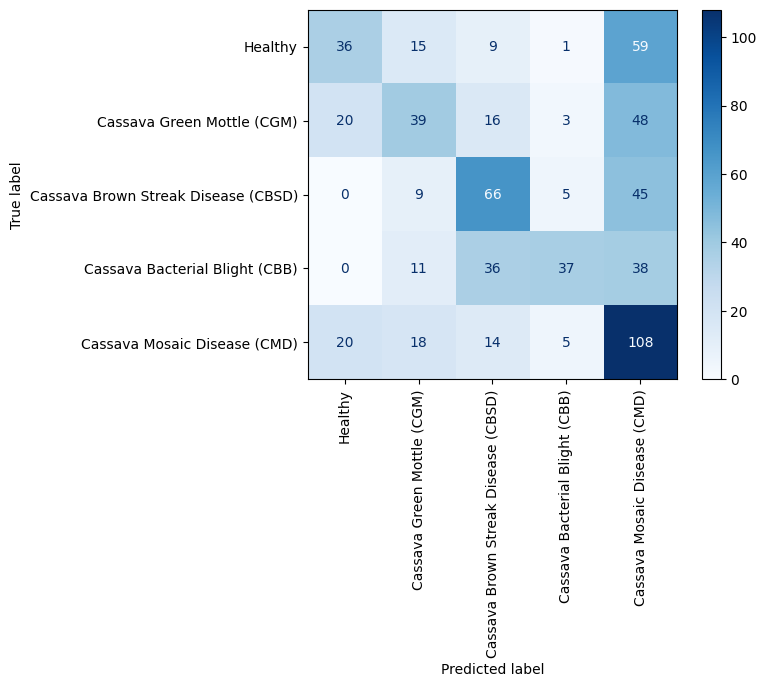

In [ ]:
targets_val = torch.cat([labels for _, labels in tqdm(val_loader, desc="Get Labels")])

cm = confusion_matrix(targets_val.cpu(), predictions_val.cpu())

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)

# Set figure size
plt.figure(figsize=(10, 8))

disp.plot(cmap=plt.cm.Blues, xticks_rotation="vertical");